In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 150 #extend width

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"]=20,10 #increase plot size

In [3]:
def length_col(col):
  return np.vectorize(len)(col.values.astype(str))

In [4]:
def print_max_length(col):
  print(col.name , ' max char length: ' , length_col(col).max(axis=0))

In [5]:
def word_col(col):
  return (col.str.split().str.len())

In [6]:
def print_max_word(col):
  print(col.name , ' max nr. words: ' ,word_col(col).max(axis=0))

In [7]:
def download_data_in_dataframe(url):
  from urllib.request import urlopen
  import json
  import pandas as pd
  response = urlopen(url)
  json_data = response.read().decode('utf-8', 'replace')
  d = json.loads(json_data)
  df = pd.json_normalize(d["questions"]).set_index('id')
  return df

In [8]:
def drop_columns(df):
  del df['answertype']
  del df['aggregation']
  del df['onlydbo']
  del df['hybrid']

In [9]:
def save_csv_to_gdrive(df, filename):
  from google.colab import drive
  drive.mount('drive')
  df.to_csv(filename)
  !mkdir "drive/My Drive/rp/" -p
  !cp "{filename}" "drive/My Drive/rp/"

In [10]:
def read_from_gdrive(filename):
  from google.colab import drive
  drive.mount('drive')
  return pd.read_csv('drive/My Drive/rp/' + filename)

In [11]:
trainingUrl="https://github.com/ag-sc/QALD/blob/master/9/data/qald-9-train-multilingual.json?raw=true"
testUrl="https://raw.githubusercontent.com/ag-sc/QALD/master/9/data/qald-9-test-multilingual.json"

In [12]:
df = download_data_in_dataframe(testUrl)

In [13]:
df.head()

,answertype,aggregation,onlydbo,hybrid,question,answers,query.sparql
id,,,,,,,
99,resource,False,True,False,"[{'language': 'de', 'string': 'In welcher Zeitzone liegt Salt Lake City?', 'keywords': 'Salt Lake City, Zeitzone'}, {'language': 'ru', 'string': ...","[{'head': {'vars': ['uri']}, 'results': {'bindings': [{'uri': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Mountain_Time_Zone'}}]}}]",PREFIX res: <http://dbpedia.org/resource/> PREFIX dbp: <http://dbpedia.org/property/> SELECT DISTINCT ?uri WHERE { res:Salt_Lake_City <http://dbpe...
98,resource,False,False,False,"[{'language': 'de', 'string': 'Wer hat Caesar getötet?', 'keywords': 'wer , Caesar, getötet'}, {'language': 'ru', 'string': 'Кто убитый Цезарь? ...","[{'head': {'vars': ['uri']}, 'results': {'bindings': [{'uri': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Marcus_Junius_Brutus_the_Young...",PREFIX dct: <http://purl.org/dc/terms/> PREFIX dbc: <http://dbpedia.org/resource/Category:> SELECT DISTINCT ?uri WHERE { ?uri dct:subject dbc:Assa...
86,resource,False,True,False,"[{'language': 'de', 'string': 'Was ist das höchste Berg im Deutschland? ', 'keywords': 'höchste , Berg , Deutschland '}, {'language': 'ru', 's...","[{'head': {'vars': ['uri']}, 'results': {'bindings': [{'uri': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Zugspitze'}}]}}]",PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> PREFIX onto: <http://dbpedia.org/on...
84,resource,False,False,False,"[{'language': 'de', 'string': 'Welche Amerikanischen Präsidenten waren während des Vietnamkriegs im Amt?', 'keywords': 'Amerikanische Präsidenten,...","[{'head': {'vars': ['uri']}, 'results': {'bindings': [{'uri': {'type': 'uri', 'value': 'http://dbpedia.org/resource/John_F._Kennedy'}}, {'uri': {'...",PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX dct: <http://purl.org/dc/terms/> PREFIX dbc: <http://...
81,resource,False,False,False,"[{'language': 'de', 'string': 'Von welchem US-Bundesstaat ist Butch Otter der Gouverneur?', 'keywords': 'US-Bundesstaat, Gouverneur, Butch Otter...","[{'head': {'vars': ['uri']}, 'results': {'bindings': [{'uri': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Idaho'}}]}}]",SELECT DISTINCT ?uri WHERE { ?uri a <http://dbpedia.org/class/yago/WikicatStatesOfTheUnitedStates> ; <http://dbpedia.org/property/governor> <http:...


In [14]:
print(df['answertype'].value_counts())
print(df['aggregation'].value_counts())
print(df['onlydbo'].value_counts())
print(df['hybrid'].value_counts())

resource    102
number       18
string       14
date         12
boolean       4
Name: answertype, dtype: int64
False    139
True      11
Name: aggregation, dtype: int64
True     120
False     30
Name: onlydbo, dtype: int64
False    150
Name: hybrid, dtype: int64


In [15]:
drop_columns(df)

In [16]:
prefixesSet = set()
def fillPrefixes(prefixString):
  for z in prefixString.strip().split('PREFIX'):
    if ':' in z: prefixesSet.add(z.strip())
def excludePrefixes(x):
  threshold = x.find("SELECT")
  if threshold == -1: threshold = x.find("ASK")
  prefix = x[:threshold]
  q = x[threshold:]
  fillPrefixes(prefix)
  return q

In [17]:
def simplify_columns():
  def simpleAnswer(answer):
    try: 
      if 'boolean' in str(answer): return answer['boolean']
      else: return answer['results']['bindings'][0][answer['head']['vars'][0]]['value']
    except: 
      print('Failure - Returning None:' + str(answer))
      return None
  df.question = df.question.apply(lambda x: [z['string'] for z in x if z['language']=='en'][0])
  df.answers = df.answers.apply(lambda x: simpleAnswer(x[0]))
  df['sparql'] = df['query.sparql'].apply(lambda x: excludePrefixes(x))
  df.rename(columns = {'query.sparql':'orig_query'}, inplace = True)

In [18]:
simplify_columns()

Failure - Returning None:{'head': {'vars': ['date']}, 'results': {}}


In [19]:
df.head()

,question,answers,orig_query,sparql
id,,,,
99,What is the time zone of Salt Lake City?,http://dbpedia.org/resource/Mountain_Time_Zone,PREFIX res: <http://dbpedia.org/resource/> PREFIX dbp: <http://dbpedia.org/property/> SELECT DISTINCT ?uri WHERE { res:Salt_Lake_City <http://dbpe...,SELECT DISTINCT ?uri WHERE { res:Salt_Lake_City <http://dbpedia.org/ontology/timeZone> ?uri }
98,Who killed Caesar?,http://dbpedia.org/resource/Marcus_Junius_Brutus_the_Younger,PREFIX dct: <http://purl.org/dc/terms/> PREFIX dbc: <http://dbpedia.org/resource/Category:> SELECT DISTINCT ?uri WHERE { ?uri dct:subject dbc:Assa...,SELECT DISTINCT ?uri WHERE { ?uri dct:subject dbc:Assassins_of_Julius_Caesar }
86,What is the highest mountain in Germany?,http://dbpedia.org/resource/Zugspitze,PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> PREFIX onto: <http://dbpedia.org/on...,SELECT ?uri WHERE { ?uri rdf:type onto:Mountain ; onto:elevation ?elevation ; onto:locatedInArea <http://dbpedia.org/resource/Germany> } ORDER BY ...
84,Which American presidents were in office during the Vietnam War?,http://dbpedia.org/resource/John_F._Kennedy,PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX dct: <http://purl.org/dc/terms/> PREFIX dbc: <http://...,SELECT ?uri WHERE { ?uri dct:subject dbc:Presidents_of_the_United_States . res:Vietnam_War dbo:commander ?uri }
81,Butch Otter is the governor of which U.S. state?,http://dbpedia.org/resource/Idaho,SELECT DISTINCT ?uri WHERE { ?uri a <http://dbpedia.org/class/yago/WikicatStatesOfTheUnitedStates> ; <http://dbpedia.org/property/governor> <http:...,SELECT DISTINCT ?uri WHERE { ?uri a <http://dbpedia.org/class/yago/WikicatStatesOfTheUnitedStates> ; <http://dbpedia.org/property/governor> <http:...


## Prefix

```
SELECT DISTINCT ?uri WHERE { ?uri rdf:type onto:Person ; onto:birthPlace <http://dbpedia.org/resource/Heraklion>. }


PREFIX dbr: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { ?uri rdf:type onto:Person ; onto:birthPlace dbr:Heraklion. }
```

In [20]:
prefixesSet

{'db: <http://dbpedia.org/>',
 'dbc: <http://dbpedia.org/resource/Category:>',
 'dbo: <http://dbpedia.org/ontology/>',
 'dbp: <http://dbpedia.org/property/>',
 'dbpedia2: <http://dbpedia.org/property/>',
 'dbr: <http://dbpedia.org/resource/>',
 'dct: <http://purl.org/dc/terms/>',
 'foaf: <http://xmlns.com/foaf/0.1/>',
 'foaf:<http://xmlns.com/foaf/0.1/>',
 'onto: <http://dbpedia.org/ontology/>',
 'owl: <http://www.w3.org/2002/07/owl#>',
 'prop: <http://dbpedia.org/property/>',
 'rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>',
 'rdfs: <http://www.w3.org/2000/01/rdf-schema#>',
 'res: <http://dbpedia.org/resource/>',
 'xsd: <http://www.w3.org/2001/XMLSchema#>',
 'yago: <http://dbpedia.org/class/yago/>'}

In [21]:
import re
pz = [re.split(':\s?<', p.replace('>','')) for p in prefixesSet]

In [22]:
pz

[['foaf', 'http://xmlns.com/foaf/0.1/'],
 ['res', 'http://dbpedia.org/resource/'],
 ['dbp', 'http://dbpedia.org/property/'],
 ['rdf', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#'],
 ['onto', 'http://dbpedia.org/ontology/'],
 ['prop', 'http://dbpedia.org/property/'],
 ['owl', 'http://www.w3.org/2002/07/owl#'],
 ['foaf', 'http://xmlns.com/foaf/0.1/'],
 ['dct', 'http://purl.org/dc/terms/'],
 ['dbpedia2', 'http://dbpedia.org/property/'],
 ['xsd', 'http://www.w3.org/2001/XMLSchema#'],
 ['dbo', 'http://dbpedia.org/ontology/'],
 ['yago', 'http://dbpedia.org/class/yago/'],
 ['db', 'http://dbpedia.org/'],
 ['rdfs', 'http://www.w3.org/2000/01/rdf-schema#'],
 ['dbc', 'http://dbpedia.org/resource/Category:'],
 ['dbr', 'http://dbpedia.org/resource/']]

In [23]:
df[df['sparql'].str.contains(r'<http://www.w3.org/1999/02/22-rdf-syntax-ns', na=True)].sparql

id
49     SELECT ?uri WHERE { ?airline <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://dbpedia.org/ontology/Airline> . ?airline <http://dbpedia.or...
39     SELECT DISTINCT ?uri WHERE { ?uri <http://dbpedia.org/ontology/occupation> <http://dbpedia.org/resource/Poet> . ?x <http://dbpedia.org/ontology/au...
194    SELECT DISTINCT ?uri WHERE { ?uri a yago:WikicatStatesOfTheUnitedStates ; <http://dbpedia.org/property/postalabbreviation> "MN"^^<http://www.w3.or...
Name: sparql, dtype: object

In [24]:
def actually_use_prefix(s):
  for p in pz:
    res = "<" + p[1]
    inx = s.find(res)
    if inx != -1: return s[:inx] + s[inx:].replace( res , p[0]+':').replace('>', '', 1)
  return s

In [25]:
s = 'SELECT DISTINCT ?uri WHERE { ?uri rdf:type onto:<Person> ; onto:birthPlace <http://dbpedia.org/resource/Heraklion>. <aaa>}'
actually_use_prefix(s)

'SELECT DISTINCT ?uri WHERE { ?uri rdf:type onto:<Person> ; onto:birthPlace res:Heraklion. <aaa>}'

In [26]:
df.sparql = df.sparql.apply(lambda x: actually_use_prefix(x))

In [27]:
def replace_dupl_prefix(s):
  return s.replace('dbr:', 'res:').replace('dbo:','onto:')

In [28]:
df.sparql = df.sparql.apply(lambda x: replace_dupl_prefix(x))

In [29]:
# removing dbo dbr
pz = [p for p in pz if not re.compile(r'dbo|dbr').search(p[0])]

In [30]:
df.head()

,question,answers,orig_query,sparql
id,,,,
99,What is the time zone of Salt Lake City?,http://dbpedia.org/resource/Mountain_Time_Zone,PREFIX res: <http://dbpedia.org/resource/> PREFIX dbp: <http://dbpedia.org/property/> SELECT DISTINCT ?uri WHERE { res:Salt_Lake_City <http://dbpe...,SELECT DISTINCT ?uri WHERE { res:Salt_Lake_City onto:timeZone ?uri }
98,Who killed Caesar?,http://dbpedia.org/resource/Marcus_Junius_Brutus_the_Younger,PREFIX dct: <http://purl.org/dc/terms/> PREFIX dbc: <http://dbpedia.org/resource/Category:> SELECT DISTINCT ?uri WHERE { ?uri dct:subject dbc:Assa...,SELECT DISTINCT ?uri WHERE { ?uri dct:subject dbc:Assassins_of_Julius_Caesar }
86,What is the highest mountain in Germany?,http://dbpedia.org/resource/Zugspitze,PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> PREFIX onto: <http://dbpedia.org/on...,SELECT ?uri WHERE { ?uri rdf:type onto:Mountain ; onto:elevation ?elevation ; onto:locatedInArea res:Germany } ORDER BY DESC(?elevation) LIMIT 1
84,Which American presidents were in office during the Vietnam War?,http://dbpedia.org/resource/John_F._Kennedy,PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX res: <http://dbpedia.org/resource/> PREFIX dct: <http://purl.org/dc/terms/> PREFIX dbc: <http://...,SELECT ?uri WHERE { ?uri dct:subject dbc:Presidents_of_the_United_States . res:Vietnam_War onto:commander ?uri }
81,Butch Otter is the governor of which U.S. state?,http://dbpedia.org/resource/Idaho,SELECT DISTINCT ?uri WHERE { ?uri a <http://dbpedia.org/class/yago/WikicatStatesOfTheUnitedStates> ; <http://dbpedia.org/property/governor> <http:...,SELECT DISTINCT ?uri WHERE { ?uri a <http://dbpedia.org/class/yago/WikicatStatesOfTheUnitedStates> ; <http://dbpedia.org/property/governor> res:Bu...


In [31]:
print('Question:')
print_max_length(df.question)
print_max_word(df.question)

print('\nLength:')
print_max_length(df.sparql)
print_max_length(df.orig_query)

print('std:', np.std(length_col(df.orig_query)), np.std(length_col(df.sparql)))

print('\nWords:')
print_max_word(df.sparql)
print_max_word(df.orig_query)

print('std:', np.std(word_col(df.orig_query)), np.std(word_col(df.sparql)))

Question:
question  max char length:  82
question  max nr. words:  15

Length:
sparql  max char length:  462
orig_query  max char length:  563
std: 95.65156698489926 66.50969018788832

Words:
sparql  max nr. words:  45
orig_query  max nr. words:  47
std: 9.082251311700691 6.846689386525105


In [32]:
save_csv_to_gdrive(df, '04-19-2021-test.csv')

Mounted at drive


In [33]:
save_csv_to_gdrive(pd.DataFrame(pz).set_index(0), '04-19-2021-prefix-test.csv')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [34]:
def plot_nr_word(col, col2):
  plt.plot((col.str.split().str.len()).value_counts().sort_index(), label = col.name)
  plt.plot((col2.str.split().str.len()).value_counts().sort_index(), label = col.name)
  plt.legend()
  plt.show()

In [35]:
def print_stats(col):
  x = (col.str.split().str.len()).value_counts().sort_index()
  print(
      'kurtosis:', pd.DataFrame(x).kurtosis()[0],
       #For this measure, higher kurtosis corresponds to greater extremity of deviations (or outliers), and not the configuration of data near the mean.
      '\nskew:',   pd.DataFrame(x).skew()[0]
  )

![](https://upload.wikimedia.org/wikipedia/commons/c/cc/Relationship_between_mean_and_median_under_different_skewness.png)

![](https://upload.wikimedia.org/wikipedia/commons/f/f8/Negative_and_positive_skew_diagrams_%28English%29.svg)

In [36]:
print_stats(df.sparql)
print_stats(df.orig_query)

kurtosis: 19.50815381554239 
skew: 4.216255485782567
kurtosis: 10.01783945681269 
skew: 3.099876323222786


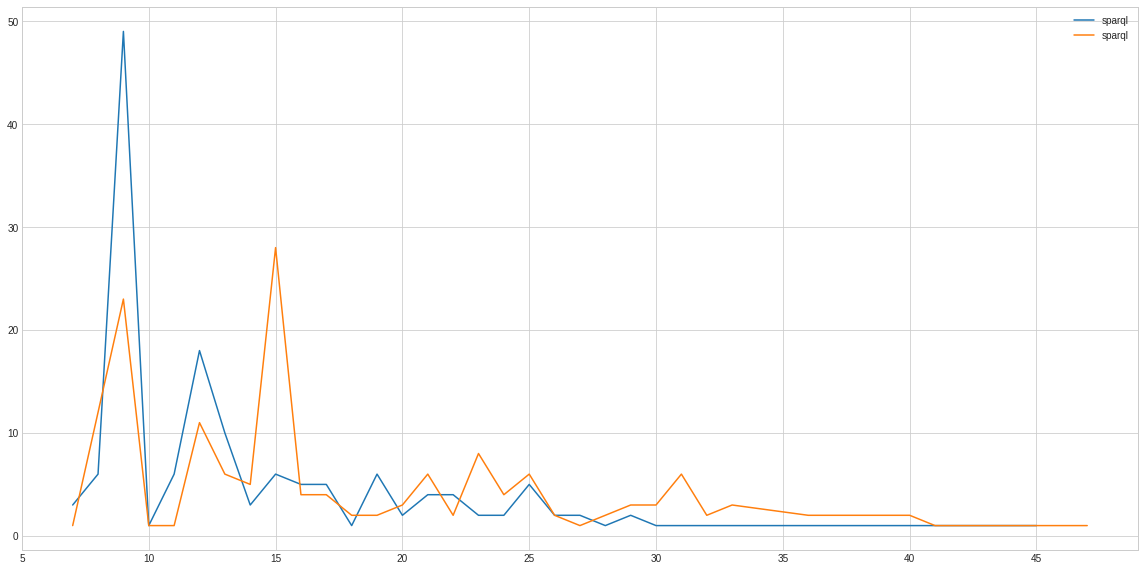

In [37]:
plot_nr_word(df.sparql, df.orig_query)